# RADOLAN adjustment example with OpenMRG CML data 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr

import mergeplg as mrg

## Load OpenMRG data

In [3]:
ds_rad, ds_cmls, ds_gauges, ds_gauges_smhi = mrg.io.load_and_transform_openmrg_data()

Transform the CML data from `Dataset` to `DataFrame` because the old RADOLAN code expects this as input, also with some specific colums that have to be present

In [4]:
df_cmls = mrg.radolan.io.transform_openmrg_data_for_old_radolan_code(ds_cmls)

## Calculate intersection weights

These need to be passed into the function that does the adjustment

In [5]:
# x_grid, y_grid = np.meshgrid(ds_rad.x.values, ds_rad.y.values)

intersection_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_x.values,
    y1_line=ds_cmls.site_0_y.values,
    x2_line=ds_cmls.site_1_x.values,
    y2_line=ds_cmls.site_1_y.values,
    cml_id=ds_cmls.cml_id.values,
    x_grid=ds_rad.xs.data,
    y_grid=ds_rad.ys.data,
    grid_point_location="lower_left",
)

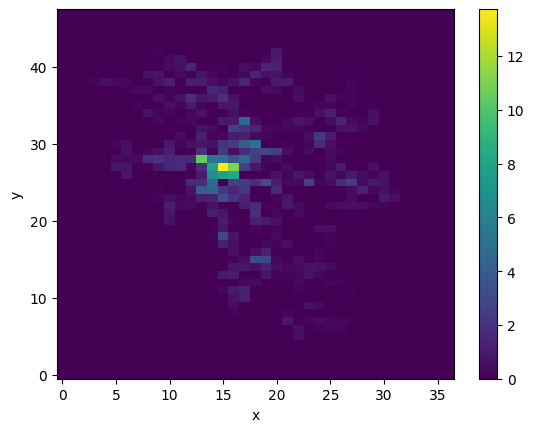

In [6]:
intersection_weights.sum(dim="cml_id").plot();

## Loop through all time stamps and do adjustment

In [7]:
# need to set this variable since the old RADOLAN code starts with this
ds_rad["RH"] = ds_rad.rainfall_amount

In [8]:
ds_radolan_t_list = []
df_stations_t_list = []
for t in ds_rad.time.data:
    ds_radolan_t, df_stations_t = mrg.radolan.processing.rh_to_rw(
        ds_radolan_t=ds_rad.sel(time=t),
        df_stations_t=df_cmls.loc[t, :],
        allow_gauge_and_cml=True,
        intersect_weights=intersection_weights,
        max_distance=30e3,
    )
    ds_radolan_t_list.append(ds_radolan_t)
    df_stations_t_list.append(df_stations_t)

ds_radolan = xr.concat(ds_radolan_t_list, dim="time")

The adjusted product is called `RW`. Note that for DWD's radar-adjustment product, the `RW` product is an hourly radar-gauge adjustment. Here, we apply the same adjustment steps to the 5min data. Radar-adjustment at this temporal resolution is challenging due to spatio-temporal mismatch of radar observations and ground observations from gauge and/or CML.

All intermediate products of the RADOLAN adjustment method are stored in the returned xr.Dataset

In [9]:
ds_radolan.data_vars

Data variables:
    crs                          (time) int32 124B 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    latitudes                    (time, y, x) float32 220kB 57.21 ... 58.06
    longitudes                   (time, y, x) float32 220kB 11.41 ... 12.66
    rainfall_amount              (time, y, x) float64 440kB 0.01078 ... 0.05403
    RH                           (time, y, x) float64 440kB 0.01078 ... 0.05403
    RG                           (time, y, x) float64 440kB 0.01078 ... 0.05403
    RB                           (time, y, x) float64 440kB 0.01078 ... 0.05403
    dbr_interim                  (time, y, x) float64 440kB 0.0 0.0 ... 0.0 0.0
    fbr_interim                  (time, y, x) float64 440kB 1.0 1.0 ... 1.0 1.0
    addiff_interim               (time, y, x) float64 440kB 0.01078 ... 0.05403
    mulfak_interim               (time, y, x) float64 440kB 0.01078 ... 0.05403
    weight_addiff_interim_audit  (time, y, x) float64 440kB 0.5 0.5 ... 0.5 0.5
    weight_mulfak_interim_audit

## Compare unadjusted and adjusted radar rainfall fields

### Look at rainfall sum of example dataset

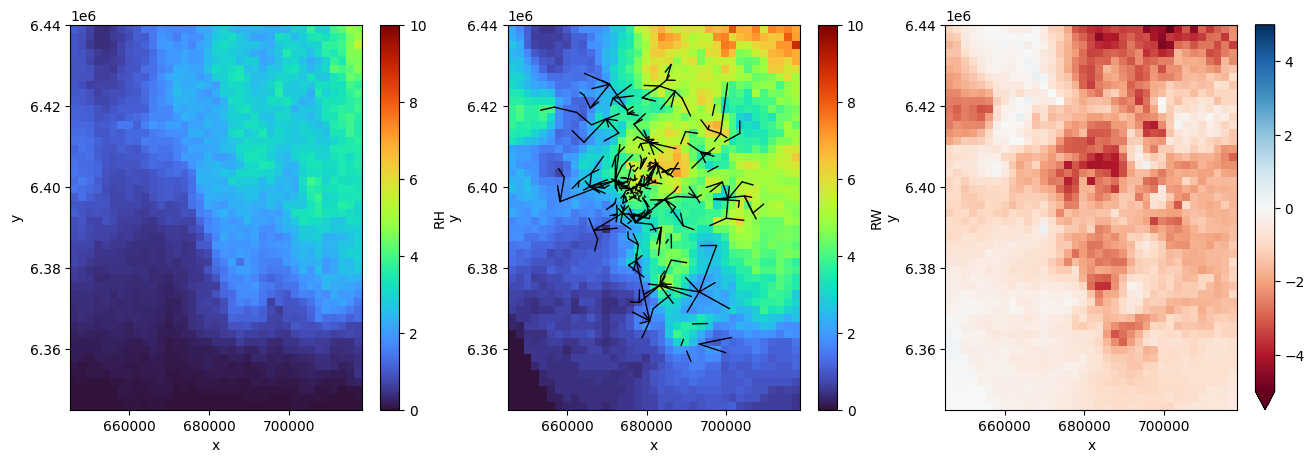

In [10]:
vmin, vmax = 0, 10
cmap = "turbo"
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
ds_radolan.sum(dim="time").RH.plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap=cmap)
ds_radolan.sum(dim="time").RW.plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap=cmap)
(ds_radolan.sum(dim="time").RH - ds_radolan.sum(dim="time").RW).plot(
    ax=axs[2],
    vmin=-5,
    vmax=5,
    cmap="RdBu",
)

plg.plot_map.scatter_lines(
    x0=ds_cmls.site_0_x,
    x1=ds_cmls.site_1_x,
    y0=ds_cmls.site_0_y,
    y1=ds_cmls.site_1_y,
    ax=axs[1],
    s=1,
    c="k",
)

### Look at individual time stamps

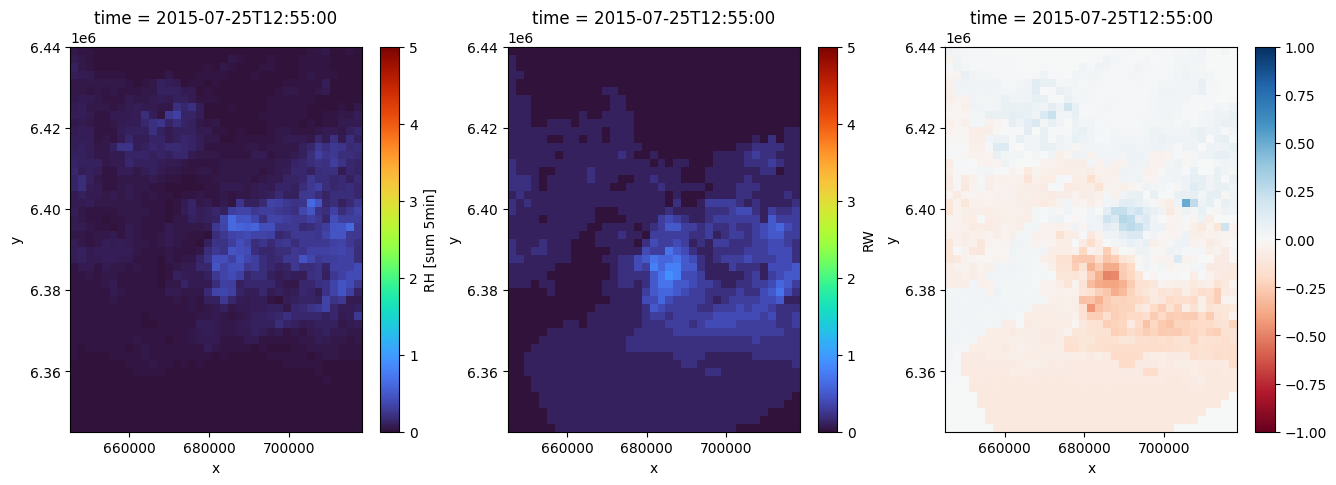

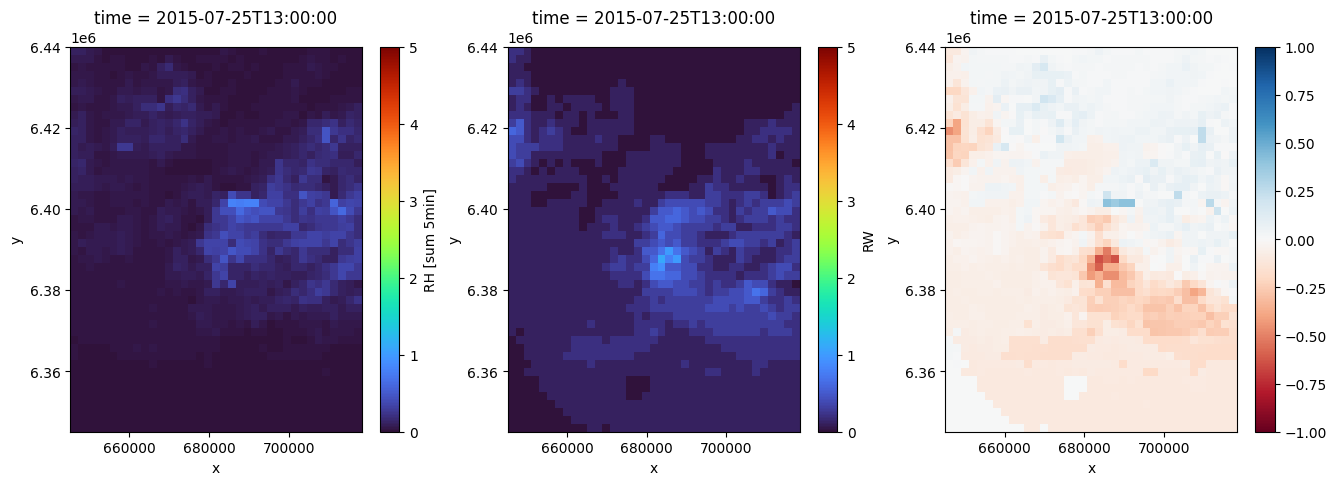

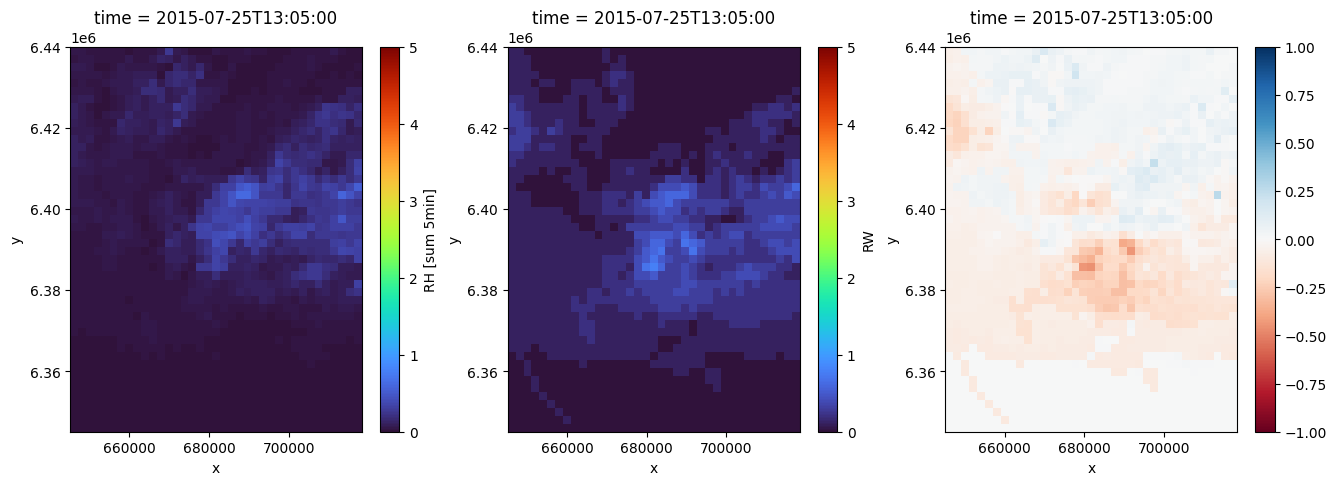

In [11]:
for t in ds_radolan.time.data[5:8]:
    vmin, vmax = 0, 5
    cmap = "turbo"
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    ds_radolan.sel(time=t).RH.plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap=cmap)
    ds_radolan.sel(time=t).RW.plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap=cmap)
    (ds_radolan.sel(time=t).RH - ds_radolan.sel(time=t).RW).plot(
        ax=axs[2],
        vmin=-1,
        vmax=1,
        cmap="RdBu",
    )

## Validate unadjusted and adjusted radar rainfall fields at gauge locations

In [12]:
# We need to add these to comply with the OPENSENSE naming conventions
ds_rad.coords["lon"] = ds_rad.longitudes
ds_rad.coords["lat"] = ds_rad.latitudes

grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,
    nnear=1,
)

ds_gauges.coords["id"] = ds_gauges.station_id

In [13]:
radar_at_gauges = grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,
)

RW_at_gauges = grid_at_points(
    da_gridded_data=ds_radolan.RW_not_rounded,
    da_point_data=ds_gauges.rainfall_amount,
)

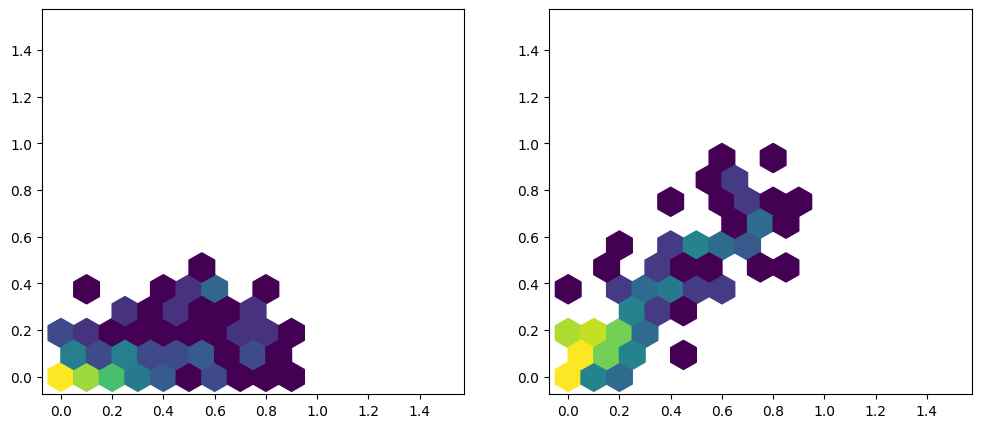

In [14]:
extent = [0, 1.5, 0, 1.5]
gridsize = 15

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hexbin(
    ds_gauges.rainfall_amount,
    radar_at_gauges,
    mincnt=1,
    extent=extent,
    gridsize=gridsize,
    bins="log",
)

axs[1].hexbin(
    ds_gauges.rainfall_amount,
    RW_at_gauges,
    mincnt=1,
    extent=extent,
    gridsize=gridsize,
    bins="log",
);

In [15]:
R_gauge = ds_gauges.rainfall_amount.data.flatten()
R_unadjusted = radar_at_gauges.data.flatten()
R_adjusted = RW_at_gauges.data.flatten()

corr_unadjusted = np.corrcoef(R_gauge, R_unadjusted)[0, 1]
corr_adjusted = np.corrcoef(R_gauge, R_adjusted)[0, 1]

rmse_unadjusted = np.sqrt(np.mean((R_gauge - R_unadjusted) ** 2))
rmse_adjusted = np.sqrt(np.mean((R_gauge - R_adjusted) ** 2))

print("  unadjusted adjusted")
print(f"PCC:  {corr_unadjusted:0.2f}     {corr_adjusted:0.2f}")
print(f"RMSE: {rmse_unadjusted:0.2f}     {rmse_adjusted:0.2f}")

  unadjusted adjusted
PCC:  0.63     0.87
RMSE: 0.20     0.11
